The Alzheimer's Disease Multiclass Dataset contains approximately 44,000 MRI images categorized into four distinct classes based on the severity of Alzheimer's disease. This dataset is intended for use in machine learning model training and testing. All images are skull-stripped and clean of non-brain tissue.

**Dataset Structure**
The dataset is organized into the following four directories, each representing a different class of disease severity:
- `NonDemented`: Contains 12,800 MRI images of subjects with no signs of dementia.
- `VeryMildDemented`: Contains 11,200 MRI images of subjects with very mild symptoms of dementia.
- `MildDemented`: Contains 10,000 MRI images of subjects with mild dementia.
- `ModerateDemented`: Contains 10,000 MRI images of subjects with moderate dementia.

**Image Details**
- Total Number of Images: 44,000
- Image Format: MRI scans as .JPG files
- Image Usage: Suitable for training and testing machine learning models focused on classifying Alzheimer's disease stages.

**Disease Severity Classification**
The dataset follows a severity ranking system for Alzheimer's disease:
- NonDemented: No dementia.
- Very Mild Demented: Early signs of dementia, very mild symptoms.
- Mild Demented: Clear signs of dementia, but still mild.
- Moderate Demented: More pronounced symptoms of dementia, moderate severity.

Our Aim is to build a Neural Network Model to be able to predict the severity of Patient's Alzheimer's disease, given the medical image of the Patient's MRI Scan.

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.cm as cm

## Taking a look at 5 random Images from each classes

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


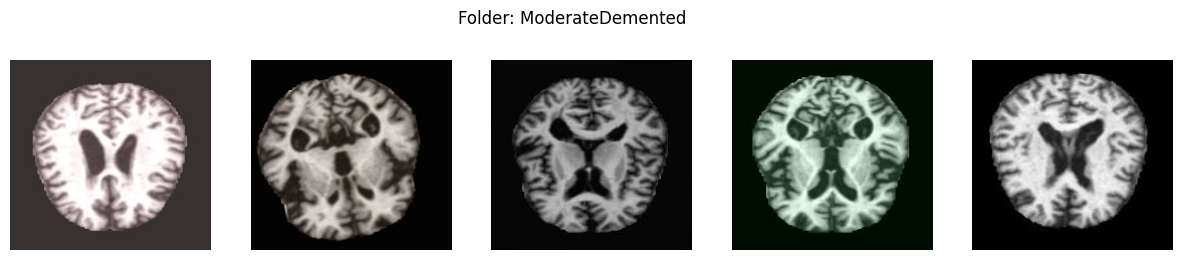

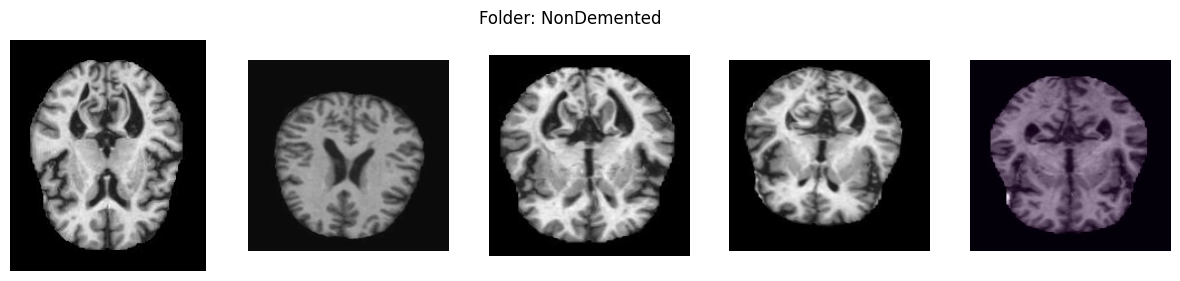

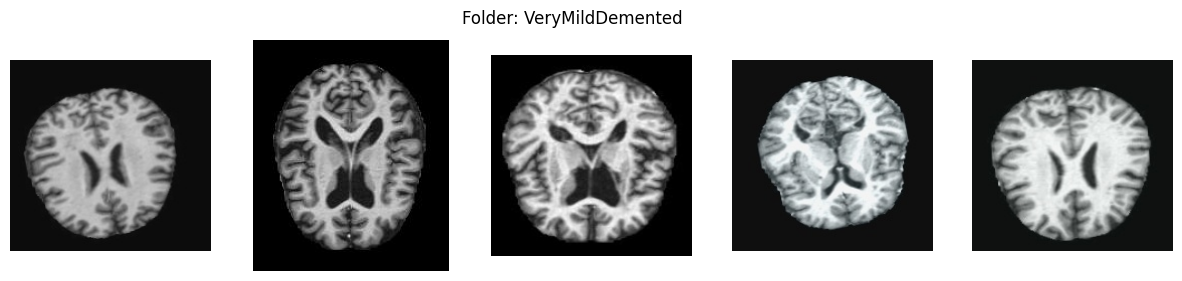

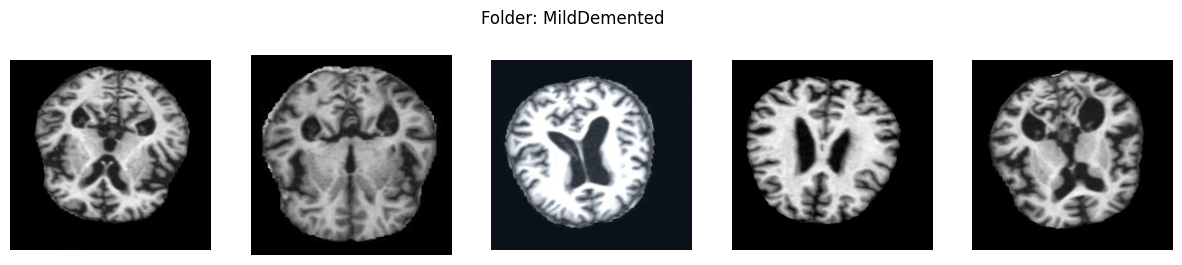

In [2]:
working_directory = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images"
img_folders = os.listdir(working_directory)
print(img_folders)

for folder in img_folders:
    target_dir = os.path.join(working_directory, folder)
    five_images = os.listdir(target_dir)[:5]

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))  

    for ax, path in zip(axes, five_images):
        img_path = os.path.join(target_dir, path)
        img = Image.open(img_path).convert('RGB') 
        ax.imshow(img)
        ax.axis('off')

    plt.suptitle(f"Folder: {folder}")
    plt.show()

We see 5 images above from each of the different classes of Alzheimer present in our Dataset.

Let's store the information about the Folder structures and it's classes in a DataFrame.

## Storing Image Data in a DataFrame

In [30]:
data = []
for folder_name in os.listdir(working_directory):
    folder_path = os.path.join(working_directory, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            data.append({
                'FilePath': os.path.join(folder_path, img_name),
                'Label': folder_name
            })

df = pd.DataFrame(data)
print(f"Total images found and stored in the DataFrame: {len(df)}")
df.head()

Total images found and stored in the DataFrame: 44000


,FilePath,Label
0,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
1,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
2,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
3,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented
4,/kaggle/input/alzheimers-multiclass-dataset-eq...,ModerateDemented


## Analyzing the Distribution of the classes

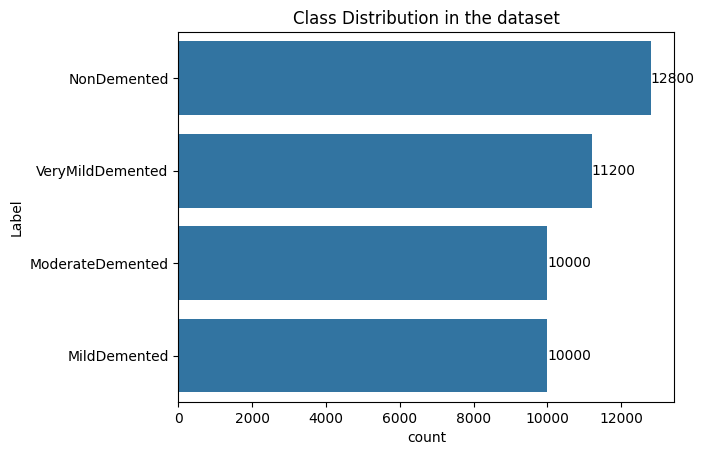

In [4]:
sns.countplot(data=df, y='Label',order=df['Label'].value_counts().index)
plt.title('Class Distribution in the dataset')
ax = plt.gca()
ax.bar_label(ax.containers[0])
plt.show()

We have more NonDemented and VeryMildDemented than ModerateDemented and MildDemented.

We would be careful when splitting the dataset to ensure that there is a balance between our Training, Validation and Testing Set.

Let's explore the Physical Properties of Images, most especially the Image Size and the Color Channels of the Images.

## Extract Image Size and Color Channels for all images

In [5]:
def read_image_metadata(path):
    try:
        with Image.open(path) as img:
            return [img.size[0], img.size[1], img.size, img.mode, len(img.getbands())]
    except:
        return [None, None, None, None, None]

def collect_image_metadata(df):
    num_cores = cpu_count()
    print(f"Launching {num_cores} parallel workers...")
    
    with Pool(num_cores) as pool:
        results = list(tqdm(pool.imap(read_image_metadata, df['FilePath']), 
                           total=len(df), 
                           desc="Multiprocessing Extraction"))
    
    meta_columns = ['Width', 'Height', 'Size', 'Mode', 'Channels']
    meta_df = pd.DataFrame(results, columns=meta_columns)
    
    return pd.concat([df.reset_index(drop=True), meta_df], axis=1)

df = collect_image_metadata(df)

Launching 4 parallel workers...


Multiprocessing Extraction: 100%|██████████| 44000/44000 [01:27<00:00, 503.56it/s]


In [36]:
print(f"Number of Images that failed to process: {df['Width'].isnull().sum()} images")

print("\nDistribution of Image Sizes")
df['Size'].value_counts().reset_index()

Number of Images that failed to process: 0 images

Distribution of Image Sizes


,Size,count
0,"(200, 190)",31107
1,"(180, 180)",6447
2,"(176, 208)",6446


The images don't have a single size, we have more images of size `120 by 120`, compared to `180 by 180` and `176 by 208`.
We will have to unify this sizes and set them to a preferred size for our model.

We can also explore more about the sizes to see if if they are tied to their classes. 


In [45]:
# Bias Audit of Size and their Labels
df.groupby(['Size', 'Label']).size().unstack()

Label,MildDemented,ModerateDemented,NonDemented,VeryMildDemented
Size,,,,
"(176, 208)",911,95,3200,2240
"(180, 180)",913,94,3200,2240
"(200, 190)",8176,9811,6400,6720


The result above shows that the dataset is robust against metadata shortcuts (Labels cannot be easily inferred based on Image size). 

We can safely assume that because no single size is exclusive to a single label, the model cannot "cheat" by simply looking at the image dimensions to guess the disease stage.

It is also clear that majority of the images are in the `200 by 190` scale.

Time to check the distribution of the mode/color channel of the images:

In [39]:
print("\nDistribution of Image Modes/Channels")
df['Mode'].value_counts().reset_index()


Distribution of Image Modes/Channels


,Mode,count
0,RGB,33984
1,L,10016


10k of the images are greyscale images, we will have to force them into RGB Modes.

This is because our proposed model - the **EfficientNet** expect 3 channels or RGB Images. If our data loader hits a 1-channel image while expecting 3, it would throw a dimension mismatch error.

We will carry out the following preprocessing step:

- Image resizing with aspect ratio preservation and padding: Each image will be scaled so that its longest side is 224 pixels, after which zero-padding will be applied to the shorter side to obtain a square image of size 224 × 224.

The choice of 224 × 224 is motivated by transfer-learning conventions and aligns with the native input resolution of EfficientNet-B0. 

- Split the data into Training, Validation and Testing Test:
We will distribute in the following proportions:
    - Train Set (80%): $35,200$ images.
    - Validation Set (10%): $4,400$ images.
    - Test Set (10%): $4,400$ images.

## Splitting the Dataset

In [47]:
train_val_df, test_df = train_test_split(
    df, 
    test_size=0.10, 
    stratify=df['Label'],
    random_state=42  
)

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.1111, 
    stratify=train_val_df['Label'], 
    random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 35200 | Val: 4400 | Test: 4400



TRAIN DISTRIBUTION

Label
NonDemented         29.090909
VeryMildDemented    25.454545
MildDemented        22.727273
ModerateDemented    22.727273
Name: proportion, dtype: float64


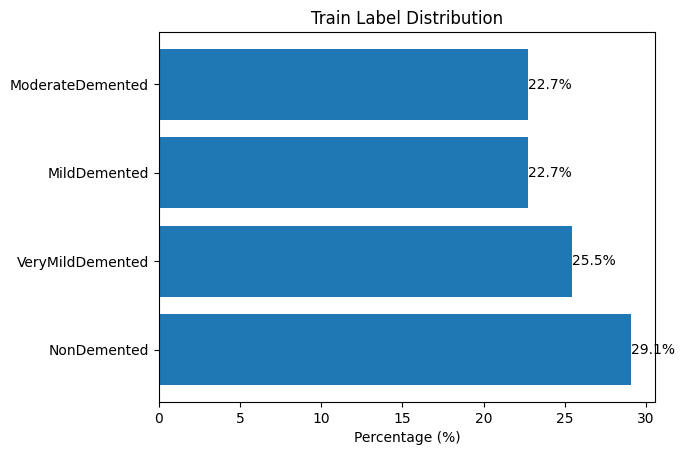

________________________________________________________________________________________________________________________

VALIDATION DISTRIBUTION

Label
NonDemented         29.090909
VeryMildDemented    25.454545
ModerateDemented    22.727273
MildDemented        22.727273
Name: proportion, dtype: float64


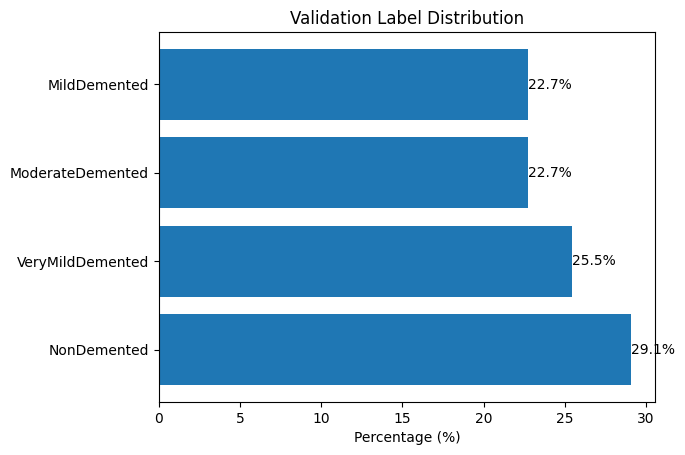

________________________________________________________________________________________________________________________

TEST DISTRIBUTION

Label
NonDemented         29.090909
VeryMildDemented    25.454545
ModerateDemented    22.727273
MildDemented        22.727273
Name: proportion, dtype: float64


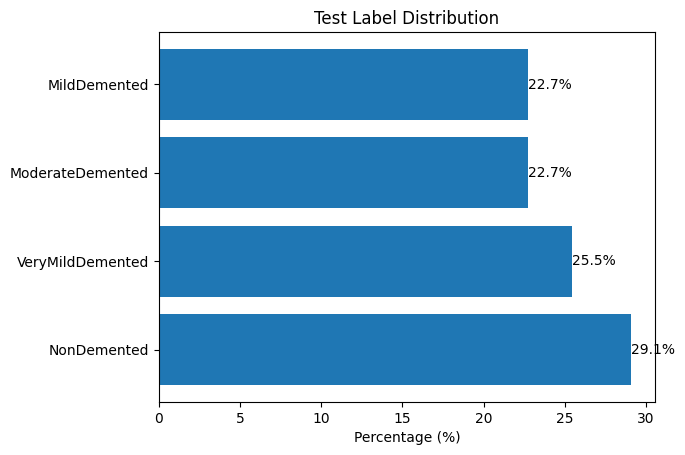

________________________________________________________________________________________________________________________


In [64]:
def check_ratios(dfs, names):
    
    for df, name in zip(dfs, names):
        print(f"\n{name} Distribution\n".upper())

        percentages = df["Label"].value_counts(normalize=True) * 100
        print(percentages)

        
        fig, ax = plt.subplots()
        ax.barh(
            percentages.index.astype(str),
            percentages.values
        )
        ax.set_xlabel("Percentage (%)")
        ax.set_title(f"{name} Label Distribution")

        ax.bar_label(
            ax.containers[0],
            fmt="%.1f%%"
        )

        plt.show()
        print("____" * 30)
        

check_ratios([train_df, val_df, test_df],["Train", "Validation", "Test"])

We can observe that the classes are well distributed accross all splits.

We will use the splits for the following:
- Training Set: This will be used by the model to learn the MRI patterns.
- Validation Set: This will be used during training to evaluate the model.
- Test Set: This stays completely untouched and unused until the very end to prove our model works on unseen data, to evaluate it's finalgeneralization power.

Time to encode the Label names...

## Preprocessing the different Splits

In [ ]:
label_map = {
    'NonDemented': 0,
    'VeryMildDemented': 1,
    'MildDemented': 2,
    'ModerateDemented': 3
}

train_df['LabelNum'] = train_df['Label'].map(label_map)
val_df['LabelNum'] = val_df['Label'].map(label_map)
test_df['LabelNum'] = test_df['Label'].map(label_map)


We will load the dataset into a stream for our model.

In [13]:
BATCH_SIZE = 32
# IMG_SIZE = (224, 224)

def load_and_preprocess(path, label):
    # Read Image
    img = tf.io.read_file(path)
    # Force any image mode to RGB Mode/Channel
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize and Pad
    img = tf.image.resize_with_pad(img, 224, 224)
    img = tf.cast(img, tf.float32) 
    return img, label


def create_dataset(dataframe, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['FilePath'].values, dataframe['LabelNum'].values))
    # Using all CPU cores
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    # Batch and prefetch to keep the GPU busy
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Creating the stream for all Splits
train_ds = create_dataset(train_df, shuffle=True)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

I0000 00:00:1768835303.325991      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Building the Model

In [16]:
def build_model(num_classes):
    # Loading the pre-trained EfficientNetB0
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(), 
        layers.BatchNormalization(),    
        layers.Dropout(0.4),        
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Initializing our Model
model = build_model(num_classes=4)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [17]:
# Compiling our model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    # Lower the learning rate if we get 'stuck' on a plateau
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3),
    # Save the best version of our model automatically
    tf.keras.callbacks.ModelCheckpoint('alzheimer_model.keras', save_best_only=True)
]

**⚠️NOTE**:

Run this cell below if there are more than 1 GPU in the current runtime.
This will allow the efficient utilisation of ALL AVAILABLE GPUs and will Speed Up the Training Process significantly.

In [18]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

# Build and Compile within the Scope
with strategy.scope():
    # Load base model
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False 
    
    # Build architecture for the scope
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


## Training the Model

In [19]:
# Launching the training with 40 Epochs
EPOCHS = 40

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks 
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/40


E0000 00:00:1768835429.657285      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1768835431.373732     153 cuda_dnn.cc:529] Loaded cuDNN version 91002


1099/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5650 - loss: 1.0907INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.5651 - loss: 1.0904 - val_accuracy: 0.7382 - val_loss: 0.5810 - learning_rate: 0.0010
Epoch 2/40
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 60s 54ms/step - accuracy: 0.6840 - loss: 0.7147 - val_accuracy: 0.7786 - val_loss: 0.5110 - learning_rate: 0.0010
Epoch 3/40
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 60s 54ms/step - accu

### <u>Observations</u>
- The model completed all 40 epochs without early termination, and the training loss decreased consistently across epochs, indicating stable optimization.

- A clear learning trend was evident from the first epoch, with the model achieving a **validation accuracy of approximately 73.8%** in it's first epoch. This demonstrates that the pretrained backbone provided meaningful feature representations prior to extensive task-specific training.

- Validation accuracy consistently exceeded training accuracy across all epochs, indicating effective regularization through Dropout and Batch Normalization and no observable overfitting during training.

- A learning rate reduction was applied at epoch 35, after which validation performance continued to improve, confirming the benefit of adaptive learning rate scheduling.

- Training time was approximately `60` seconds per epoch, for a total duration of `~40` minutes

- Training ended with a Validation Accuracy of `0.9659`, appromixmately `0.966`.


## Evaluate the Model on Testing Split/Set

Running diagnostic on Test Set...
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step


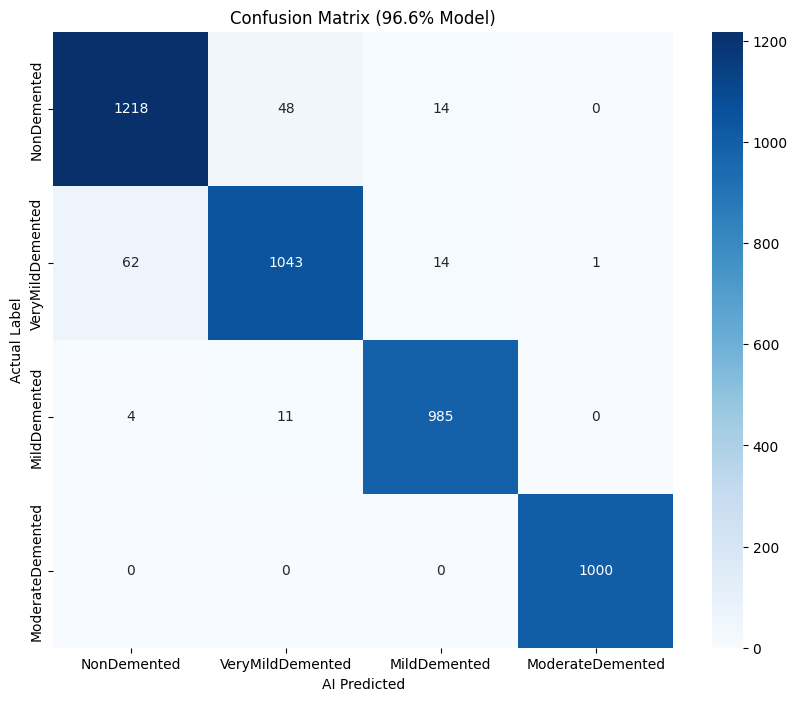

                  precision    recall  f1-score   support

     NonDemented       0.95      0.95      0.95      1280
VeryMildDemented       0.95      0.93      0.94      1120
    MildDemented       0.97      0.98      0.98      1000
ModerateDemented       1.00      1.00      1.00      1000

        accuracy                           0.96      4400
       macro avg       0.97      0.97      0.97      4400
    weighted avg       0.96      0.96      0.96      4400



In [21]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get Model's Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_map.keys(), 
            yticklabels=label_map.keys())
plt.xlabel("Model's Predicted")
plt.ylabel('Actual Label')
plt.title('Confusion Matrix (96.6% Model)')
plt.show()


# Get Classification Report 
print(classification_report(y_true, y_pred, target_names=label_map.keys()))

We obseved an oustanding score of the model for Moderate Cases:
* **Precision:** 1.00 (100%)
* **Recall:** 1.00 (100%)
  
Our model **NEVER** missed a severe case. This is the most critical metric because missing a severe patient is dangerous.

And in the case of Non, Mild and Very Mild
* The model confused **62** "Very Mild" patients as "Non Demented" (False Negatives).
But it rarely confused "Non Demented" with "Moderate" (0 times). This means the model isn't guessing when it comes to Moderate Cases..

 
We have been able to achieve an accuracy of `96.6%` with `100%` recall on the most severe class/case. 

| Metric | Our Result |
| --- | --- |
| **Accuracy** | **96.6%** | 
| **Recall** | **100%** |